Lilly Grella

*   Data Engineering Systems Week 9 Mini-Project

*   This project attempts to setup, configuration, and perform data manipulation in colab

**This notebook performs the following activities:**


1.   Reads in data using the yahoo finance api
2.   Determine which pairs are cointegrated/correlated for the concept of pairs trading in quant finance
3.   Visualizes this cointegration
4.   Determines the threshold for when we should long and short each chosen cointegrated pair
5.   Throughout the exercise, I perform a variety of data visualizations mostly focused on line graphs and heat maps.




In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import seaborn
import matplotlib.pyplot as plt

In [ ]:
import yfinance as yf

symbol_list = ['AON', "BAH",'CACI','MMC','SPY']
data = yf.download(
    symbol_list,
    start='2019-08-30',
    end='2023-08-30'
)['Adj Close']

print(data.head())

[*********************100%%**********************]  5 of 5 completed
                   AON        BAH        CACI        MMC         SPY
Date                                                                
2019-08-30  188.267609  70.458229  222.289993  93.545631  273.118683
2019-09-03  186.103241  70.364929  220.990005  92.524872  271.521698
2019-09-04  188.799011  71.437988  222.320007  93.620567  274.603546
2019-09-05  188.992249  71.941864  227.100006  94.631981  278.133698
2019-09-06  188.683090  71.456642  227.039993  94.500854  278.348480


In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
print(pairs)

[('AON', 'CACI'), ('AON', 'MMC'), ('CACI', 'MMC')]


Reasoning as to Why I chose AON and MMC as a pair:

Marsh & McLennan (NYSE:MMC), rating Outperform and Aon (NYSE:AON), rating Underperform - "Two large insurance brokers with similar valuations, but MMC sports a stronger organic growth rate and less international exposure, which should result in a premium valuation over time

<Axes: >

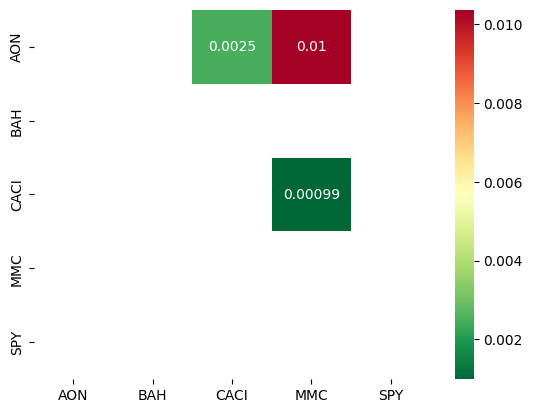

In [ ]:

seaborn.heatmap(
    pvalues,
    xticklabels=symbol_list,
    yticklabels=symbol_list,
    cmap='RdYlGn_r',
    mask = (pvalues >= .05),
    annot = True
)

0.5726818596603395
                   AON         BAH        CACI         MMC         SPY
Date                                                                  
2023-08-23  325.859985  113.699997  331.000000  191.366440  441.472778
2023-08-24  327.029999  114.760002  327.720001  191.077515  435.354370
2023-08-25  332.070007  114.540001  325.299988  193.488525  438.423523
2023-08-28  331.510010  115.050003  327.000000  194.046448  441.203735
2023-08-29  333.200012  114.419998  327.149994  195.879608  447.581238
Date
2019-08-30   -14.486988
2019-09-03   -14.265788
2019-09-04   -14.716970
2019-09-05   -13.816447
2019-09-06   -13.770134
                ...    
2023-08-23     4.752337
2023-08-24     3.793367
2023-08-25     3.318056
2023-08-28     4.196679
2023-08-29     5.062006
Length: 1006, dtype: float64


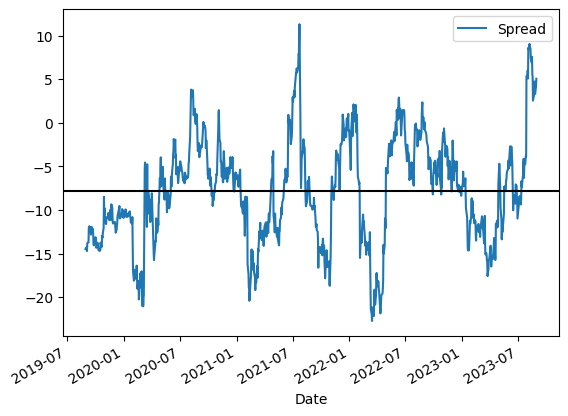

In [ ]:
S1 = data.AON
S2 = data.MMC
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = data.AON
b = results.params['AON']
spread = S2 - b * S1

spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);
print(b)
print(data.tail())
print(spread)

Date
2019-08-30   -1.095039
2019-09-03   -1.058508
2019-09-04   -1.133020
2019-09-05   -0.984300
2019-09-06   -0.976652
                ...   
2023-08-23    2.082304
2023-08-24    1.923932
2023-08-25    1.845435
2023-08-28    1.990538
2023-08-29    2.133445
Length: 1006, dtype: float64


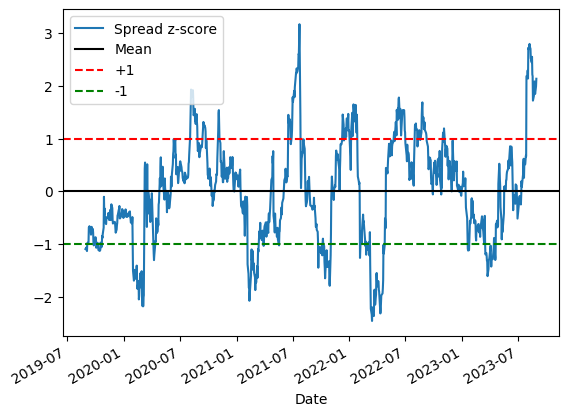

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

test = zscore(spread)
test.plot()

print(zscore(spread))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [ ]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]
# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

print("Buy AON, Sell MMC: ",trades[trades.side > 0].count()[0])
print("Buy MMC, Sell AON: ",trades[trades.side < 0].count()[0])
print("Equal to 0: ",trades[trades.side == 0].count()[0])



Buy AON, Sell MMC:  164
Buy MMC, Sell AON:  157
Equal to 0:  685


<Axes: xlabel='Date'>

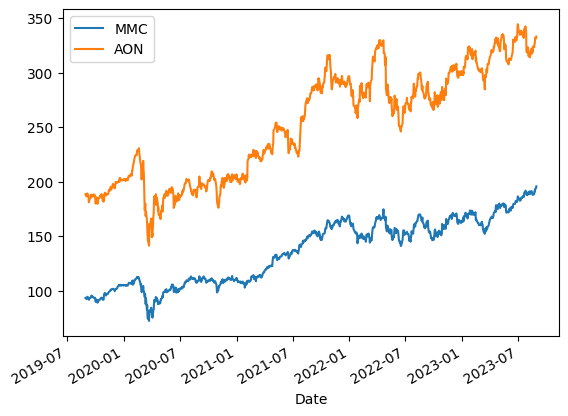

In [ ]:
df1 = data.MMC
df2 = data.AON

mmc_aon = pd.concat([df1, df2], axis=1)

# Plot the datasets
mmc_aon.plot()

In [ ]:
corr_df = data.corr()
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head()

,AON,BAH,CACI,MMC,SPY
AON,1.000000,0.747756,0.872253,0.979453,0.857943
BAH,0.747756,1.000000,0.835530,0.807086,0.623971
CACI,0.872253,0.835530,1.000000,0.871970,0.699553
MMC,0.979453,0.807086,0.871970,1.000000,0.871151
SPY,0.857943,0.623971,0.699553,0.871151,1.000000


<Figure size 640x480 with 0 Axes>

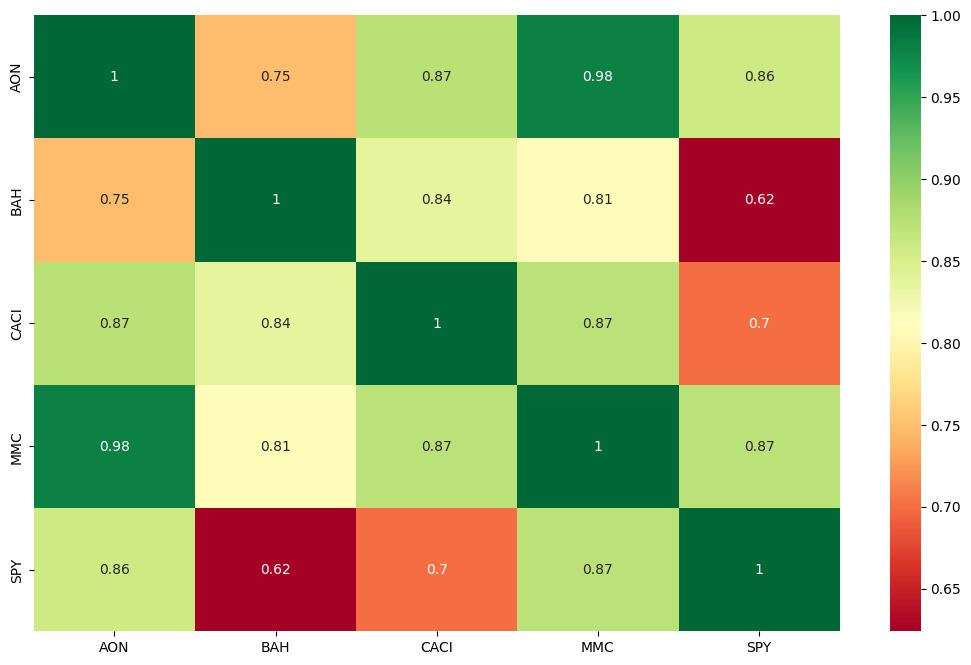

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(13, 8))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

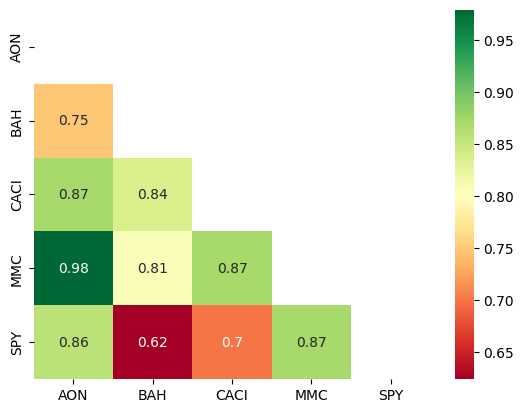

In [ ]:
# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

mask = np.zeros_like(corr_df, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn',mask = mask)

plt.show()